In [1]:
!pip install accelerate peft flash-attn pycm openai

In [2]:
import pandas as pd
df = pd.read_csv('test_hallucination.csv')
df['hallucination'] = df['hallucination'].map({'yes': 1, 'no': 0})
df.rename(columns={'hallucination': 'is_hallucination'}, inplace=True)
df = df.rename(columns={'user_query': 'input', 'chatgpt_response': 'output', 'knowledge': 'reference'})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
df.head()

,input,output,is_hallucination,reference
0,[Human]: Do you like the Princess Diaries? Who...,At the moment i do not have anything in mind.,0,The Princess Diaries has genre Romance Film
1,"Dua Lipa, an English singer, songwriter and mo...",2017,0,Her self-titled debut studio album was releas...
2,What is the nickname of the airplane model flo...,"""Triple Seven""",0,"The aircraft, a Boeing 777-200ER operated by ..."
3,"[Human]: I think Thomas Muller is cute, but ha...","He actually is on the Germany chess team, and ...",1,Thomas Müller : `~Player statistics`: Germany ...
4,[Human]: Could you recommend any movies simila...,"Yeah, it was one of the best thriller films I ...",0,Good Will Hunting has genre DramaDrama has exa...


In [4]:
from peft import PeftModel, PeftConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import pipeline
import torch

base_model_id = "microsoft/Phi-3.5-mini-instruct"
groundedai_eval_id = "grounded-ai/phi3.5-hallucination-judge"
groundedai_eval_id = 'Jlonge4/outputs'
if torch.cuda.is_bf16_supported():
  compute_dtype = torch.bfloat16
  attn_implementation = 'flash_attention_2'
# If bfloat16 is not supported, 'compute_dtype' is set to 'torch.float16' and 'attn_implementation' is set to 'sdpa'.
else:
  compute_dtype = torch.float16
  attn_implementation = 'sdpa'

config = PeftConfig.from_pretrained(groundedai_eval_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, attn_implementation=attn_implementation,torch_dtype=compute_dtype)
model_peft = PeftModel.from_pretrained(base_model, groundedai_eval_id, config=config)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)

merged_model = model_peft.merge_and_unload()
merged_model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3FlashAttention2(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMSNorm((3072

In [5]:
def format_func(reference, query, response):
  if len(str(reference)) > 1:
    prompt = f"""Your job is to evaluate whether a machine learning model has hallucinated or not.
    You are given the following information:
      ####INFO####
      [Knowledge]: {reference}
      [User Input]: {query}
      [Model Response]: {response}
      ####END INFO####
      Based on the information provided, is the model response a hallucination? Respond with only "yes" or "no"
      """
  else:
    prompt = f"""Your job is to evaluate whether a machine learning model has hallucinated or not.
    A hallucination occurs when the response is coherent but factually incorrect or nonsensical
    outputs that are not grounded in the provided context.
    You are given the following information:
      ####INFO####
      [User Input]: {query}
      [Model Response]: {response}
      ####END INFO####
      Based on the information provided, is the model output a hallucination? Respond with only "yes" or "no"
      """
  return prompt

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

def run_merged_model(reference, query, response):
  input = format_func(reference, query, response)
  messages = [
      {"role": "user", "content": input}
  ]

  pipe = pipeline(
      "text-generation",
      model=merged_model,
      tokenizer=tokenizer,
      device='cuda'
  )

  generation_args = {
      "max_new_tokens": 2,
      "return_full_text": False,
      "temperature": 0.0001,
      "do_sample": True,
  }

  output = pipe(messages, **generation_args)
  torch.cuda.empty_cache()
  return output[0]['generated_text'].strip().lower()

In [11]:
from openai import OpenAI
from getpass import getpass

API_KEY = getpass("Enter your OpenAI API key: ")
client = OpenAI(api_key=API_KEY)

Enter your OpenAI API key: ··········


In [22]:
def run_gpt4(reference, query, response):
  input = format_func(reference, query, response)

  completion = client.chat.completions.create(
      # model="gpt-4o",
      model='gpt-4o-mini',
      # model='gpt-4',
      messages=[
          {"role": "user", "content": input}
      ]
  )
  return completion.choices[0].message.content.strip().lower()

In [7]:
df_balanced = df.copy()

In [8]:
df_balanced['predictions-gai'] = df_balanced.apply(lambda x: run_merged_model(x['reference'], x['input'], x['output']), axis=1)

In [17]:
df_balanced['predictions-gpt4o'] = df_balanced.apply(lambda x: run_gpt4(x['reference'], x['input'], x['output']), axis=1)

In [23]:
df_balanced['predictions-gpt4o-mini'] = df_balanced.apply(lambda x: run_gpt4(x['reference'], x['input'], x['output']), axis=1)

In [13]:
df_balanced['predictions-gpt4'] = df_balanced.apply(lambda x: run_gpt4(x['reference'], x['input'], x['output']), axis=1)

In [26]:
len(df_balanced['predictions-gai']) == len(df_balanced['predictions-gpt4']) == len(df_balanced['predictions-gpt4o-mini']) == len(df_balanced['predictions-gpt4'])

True

In [27]:
df_balanced.reference.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200 entries, 0 to 199
Series name: reference
Non-Null Count  Dtype 
--------------  ----- 
184 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


In [9]:
PREDICTION_MAP = {"no": 0, "yes": 1}
df_balanced['predictions-gai'] = df_balanced['predictions-gai'].replace('no,', 'no')
unique_predictions = df_balanced['predictions-gai'].unique()
unique_predictions

array(['yes', 'no'], dtype=object)

In [20]:
df_balanced['predictions-gpt4o'] = df_balanced['predictions-gpt4o'].replace('no.', 'no')
unique_predictions = df_balanced['predictions-gpt4o'].unique()
unique_predictions

array(['no', 'yes'], dtype=object)

In [24]:
unique_predictions = df_balanced['predictions-gpt4o-mini'].unique()
unique_predictions

array(['no', 'yes'], dtype=object)

In [14]:
unique_predictions = df_balanced['predictions-gpt4'].unique()
unique_predictions

array(['no', 'yes'], dtype=object)

In [28]:
df_balanced.head()

,input,output,is_hallucination,reference,predictions-gai,predictions-gpt4,predictions-gpt4o,predictions-gpt4o-mini
0,[Human]: Do you like the Princess Diaries? Who...,At the moment i do not have anything in mind.,0,The Princess Diaries has genre Romance Film,yes,no,no,no
1,"Dua Lipa, an English singer, songwriter and mo...",2017,0,Her self-titled debut studio album was releas...,no,no,no,no
2,What is the nickname of the airplane model flo...,"""Triple Seven""",0,"The aircraft, a Boeing 777-200ER operated by ...",no,no,no,no
3,"[Human]: I think Thomas Muller is cute, but ha...","He actually is on the Germany chess team, and ...",1,Thomas Müller : `~Player statistics`: Germany ...,yes,yes,yes,yes
4,[Human]: Could you recommend any movies simila...,"Yeah, it was one of the best thriller films I ...",0,Good Will Hunting has genre DramaDrama has exa...,no,no,yes,yes


# Grounded-AI Hallucination Model

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.84      0.76      0.80       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

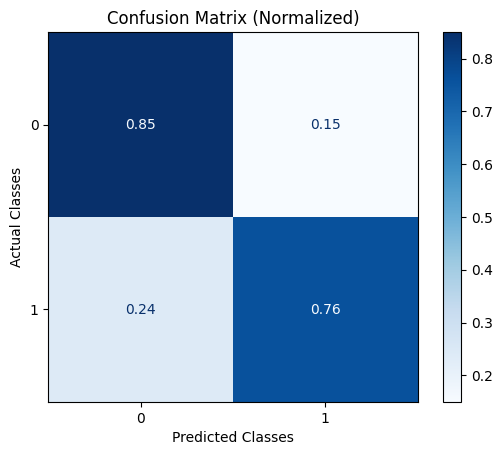

In [10]:
import numpy as np
from sklearn.metrics import classification_report
from pycm import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = df_balanced["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced["predictions-gai"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels))

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)

# GPT-4o

              precision    recall  f1-score   support

           0       0.88      0.71      0.78       100
           1       0.76      0.90      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.80       200
weighted avg       0.82      0.81      0.80       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

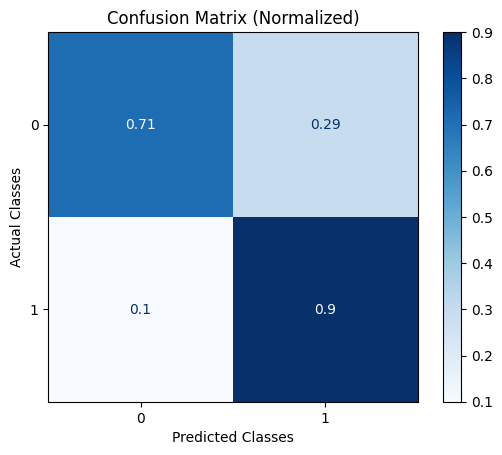

In [21]:
true_labels = df_balanced["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced["predictions-gpt4o"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels_gpt4o = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels_gpt4o))

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels_gpt4o)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)

# GPT4o-mini

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.80      0.83      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

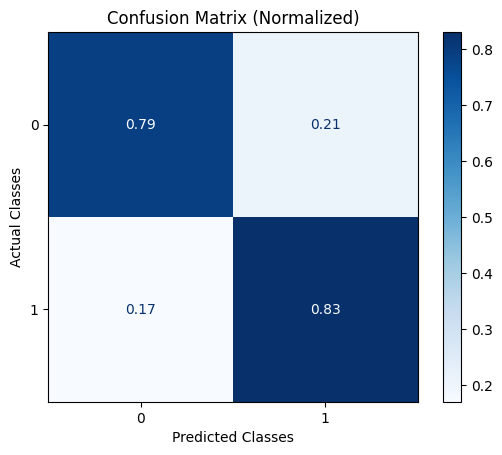

In [25]:
true_labels = df_balanced["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced["predictions-gpt4o-mini"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels_gpt4o_mini = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels_gpt4o_mini))

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels_gpt4o_mini)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)

# GPT4

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       100
           1       0.88      0.77      0.82       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

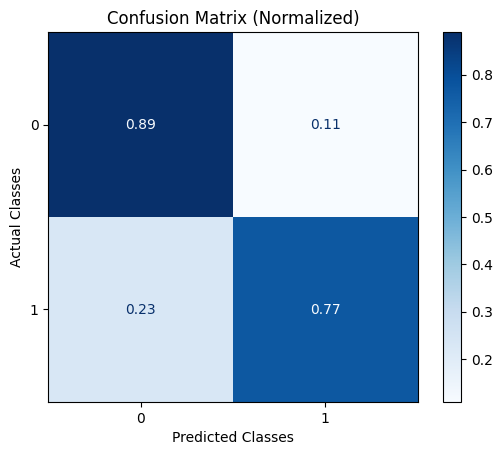

In [15]:
true_labels = df_balanced["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced["predictions-gpt4"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels_gpt4 = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels_gpt4))

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels_gpt4)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)

# Results

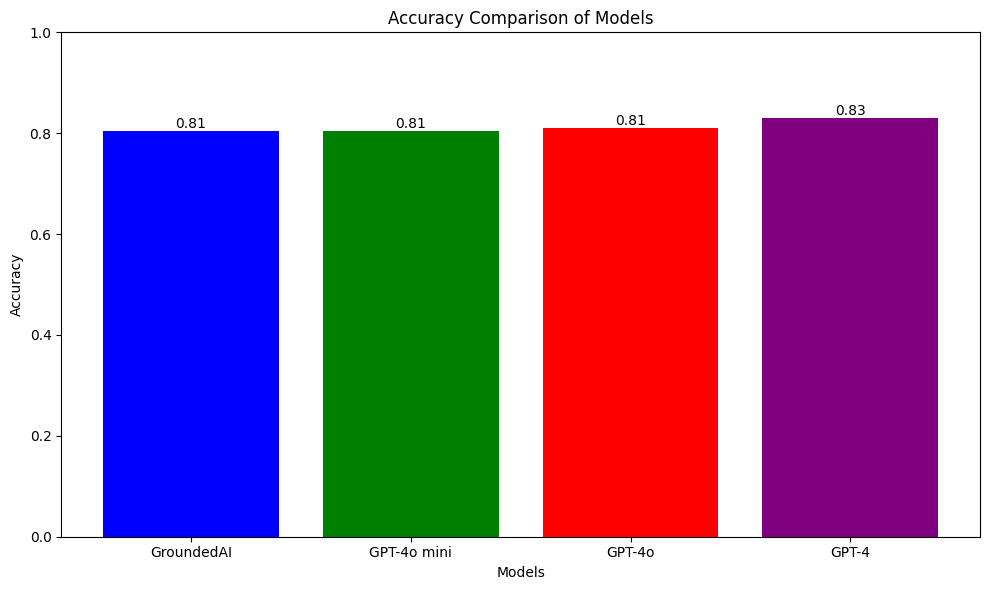

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate accuracies
accuracy_gpt4 = accuracy_score(true_labels, predicted_labels_gpt4)
accuracy_gpt4o = accuracy_score(true_labels, predicted_labels_gpt4o)
accuracy_gpt4o_mini = accuracy_score(true_labels, predicted_labels_gpt4o_mini)
accuracy_gai_model = accuracy_score(true_labels, predicted_labels)

# Create data for plotting
models = ['GroundedAI','GPT-4o mini','GPT-4o', 'GPT-4']
accuracies = sorted([accuracy_gpt4, accuracy_gpt4o, accuracy_gpt4o_mini, accuracy_gai_model])

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])

plt.title('Accuracy Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()